### Import libraries and function definitions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def calculate_completeness(row:pd.Series) -> pd.Series:
        """calculates the percentage of completeness of a level for a specific attempt"""
        goal_type = row['Goal_type']  #'n_bananas', 'n_distance' or 'n_specialcollectibles'
        return row[goal_type] /row['Goal_value']*100

### Import data frame
#### Data logs

In [2]:
# Read Dataframe
df_raw = pd.read_parquet('game_overs_compact.parquet')
#df_raw = pd.read_csv('game_overs_compact.csv')

# reanme column to match the type of goal. this is necessary to calculate the completeness.
df_raw = df_raw.rename(columns={'n_bananavalue':'n_bananas'})
df_raw.head()

,device_id,level_number,end_reason,n_bananas,n_distance,n_specialcollectibles,date_time
22,bb041952,15,win,164,217,0,2014-05-21 00:01:59
90,bb036364,13,win,298,298,0,2014-05-21 14:59:50
119,bb044331,17,swings,215,358,0,2014-05-21 00:05:00
208,bb042093,18,swings,79,395,0,2014-05-21 00:07:55
258,bb046395,5,win,0,148,0,2014-05-21 14:58:28


#### Level configurations
This file contains the goals and limitations of each level

In [3]:
#Read level configurations
levels= pd.read_csv('levels.csv')

#reanme column to match the column name of the game logs. this is necessary to merge the dataframes.
levels = levels.rename(columns={'lvl': 'level_number'})
levels.head()

,level_number,Limit_value,Goal_value,target_goal,Goal_type,Limit_type
0,1,1,30,100,n_distance,swings_limit
1,2,2,65,100,n_distance,swings_limit
2,3,1,30,100,n_distance,swings_limit
3,4,2,60,100,n_distance,swings_limit
4,5,5,100,100,n_distance,swings_limit


The idea is to combine both dataframes to have the goal and the end result for each level

In [4]:
#merge both dataframes
df_f = pd.merge(df_raw,levels,on='level_number')

With the dataframe merged, now a new column is calculated to have the percentage completeness per attempt.

In [5]:
# calculate completeness of the level based on the level goal
df_f['completeness'] = df_f.apply(calculate_completeness, axis=1)
df_f.head()

,device_id,level_number,end_reason,n_bananas,n_distance,n_specialcollectibles,date_time,Limit_value,Goal_value,target_goal,Goal_type,Limit_type,completeness
0,bb041952,15,win,164,217,0,2014-05-21 00:01:59,10,50,300,n_bananas,swings_limit,328.000000
1,bb036364,13,win,298,298,0,2014-05-21 14:59:50,15,250,2500,n_bananas,swings_limit,119.200000
2,bb044331,17,swings,215,358,0,2014-05-21 00:05:00,20,300,3000,n_bananas,swings_limit,71.666667
3,bb042093,18,swings,79,395,0,2014-05-21 00:07:55,20,250,2500,n_bananas,swings_limit,31.600000
4,bb046395,5,win,0,148,0,2014-05-21 14:58:28,5,100,100,n_distance,swings_limit,148.000000


Remove the top and bottom 5% of data before calculating metrics. This effectively "chops off" the cheaters and the players who didn't try.

In [6]:
# Removing statistical outliers
higher_bound = df_f['completeness'].quantile(0.95)
lower_bound = df_f['completeness'].quantile(0.05)
df= df_f[(df_f['completeness']<=higher_bound)&(df_f['completeness']>=lower_bound)]
print( f"Removed logs with completeness under {lower_bound}%, and {higher_bound}%")


Removed logs with completeness under 39.0%, and 170.0%


### Visualization

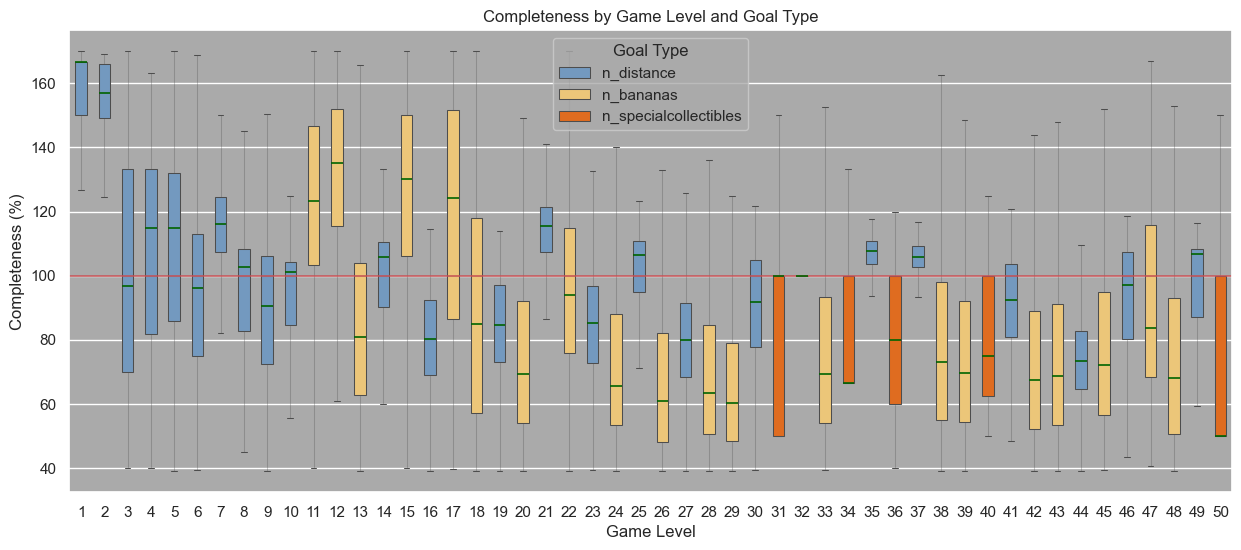

In [7]:
#sns.set_theme('paper')
goal_colors = {
    'n_bananas':"#ffcc66",
    'n_distance': "#6699cc", # Light Blue
    'n_specialcollectibles': "#ff6600"  # Light Violet
}
sns.set_theme(rc={'axes.facecolor':"#AAAAAA", 'figure.facecolor':"white"})
plt.figure(figsize=(15, 6))
ax = sns.boxplot(data=df, 
                x="level_number", 
                y="completeness",
                medianprops={"color": "darkgreen", "linewidth": 1.2},
                #fill=False,
                linewidth=.75,
                palette=goal_colors,
                hue='Goal_type',
                whiskerprops={'alpha': 0.3},
                width=0.5,
                showfliers=False
            )
ax.axhline(y=100, xmin=0, xmax=1, linewidth=1.1, color='r', linestyle='-')

for i, artist in enumerate(ax.artists):
        color_key = levels.iloc[i]['Goal_type']
        color = goal_colors[color_key]
        artist.set_edgecolor(color)

plt.title('Completeness by Game Level and Goal Type')
plt.xlabel('Game Level')
plt.ylabel('Completeness (%)')
plt.legend(title='Goal Type') # This legend is generated automatically by the 'hue' parameter
plt.savefig('./visualizations/boxplot_custom_border.png')
plt.show()

### Insights

- Levels involving **banana collection** show a drastic drop in completeness after Level 20. This indicates a sudden difficulty spike that may lead to player frustration and early churn.

- Levels 11,12 and 15 are statistically outliers for the early game. The median completeness sits significantly above 100%, and the IQR entirely avobe the 100% line suggests almost no challenge across all skill levels. 
    - **Risk:** High-skill players may perceive the game as "too easy" and lose interest during the critical retention window.

- Levels centered on **"Special Collectibles"** are consistently under-performing in success rates compared to "Distance" or "Banana" goals. This suggests the spawn rate or placement of these items is currently tuned too high for the average player.
